# Multiclass Classification

## Davis SML: Lecture 9 Part 1

## Prof. James Sharpnack

In [2]:
## Adapted from https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

import numpy as np
from sklearn import datasets, linear_model, model_selection, svm, metrics
import matplotlib.pyplot as plt

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Text(0, 0.5, 'Sepal width')

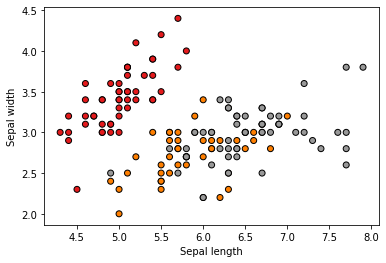

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

### Two approaches to multiclass classification

Predict $y_i \in \mathcal K = \{0,\ldots,K-1\}$ with $x_i$.

1. Train binary classifiers and then select the prediction based on these: one-vs-one trains binary classifier for each pair, one-vs-rest trains one binary classifier against class 0.

2. Train a combined classifier, where the loss uses the multiclass response.

### One-vs-one (linear case)

1. Train binary classifiers for all class pairs, $\hat \beta_{j,k}$ for $j< k \in \mathcal K$.  The prediction for this classifier is 
$$
\hat y_{i,j,k} :=
\left\{ 
\begin{array}{ll} 
    j \quad \text{ if } \hat \beta_{j,k}^\top x_i > 0\\
    k \quad \text{ if } \hat \beta_{j,k}^\top x_i \le 0
\end{array}
\right.
$$

2. Define the number of pairs that a class wins,
$$N_{i,j} = \sum_{k \ne j} 1\{ \hat y_{i,j,k} = j \text{ or } \hat y_{i,k,j} = j \}$$

3. Then the predicted class for the $i$th sample is $\arg\max_j N_{i,j}$ with ties broken at random.

This is done in `sklearn.svm.SVC`.

### One-vs-rest (linear case)

1. Train K binary classifiers for $y_i = k$ as class 1 and the rest as class -1, get $\hat \beta_k$.

2. Predict that with biggest decision function,
$$
\hat y_i = \arg \max_j \hat \beta_j^\top x_i
$$
(throughout intercept is incorporated into $\beta$'s and $x_{i,0} = 1$)

The `multi_class = 'ovr'` option in `sklearn.svm.LinearSVC` does this.

### Multiclass training

What is stopping us from using a multiclass loss?

For SVM this requires a modification of the maximum margin problem,
$$
\min \sum_j \| \beta_j\|_2^2 + C \sum_{i=1}^n \xi_i
$$
where $\beta_{y_i}^\top x_i + \beta_{y_i,0} + \xi_i \ge \beta_{j}^\top x_i + \beta_{j,0} + 1$ for all $j \ne y_i$.  (Added intercept)


__Exercise 9.1__ Convince yourself that the hinge loss is then,
$$
\max_{j \ne y_i} \left( 1 - (\beta_{y_i} - \beta_j)^\top x_i - (\beta_{y_i,0} - \beta_{j,0}) \right)_+
$$

### Logistic regression

Model is now multinomial (size=1) with
$$
\log \frac{P\{Y = k | X = x \}}{P \{ Y = 0 | X = x \}} = \beta_{k,0} + \beta_k^\top x
$$
for $k = 1,\ldots,K-1$. This is also called logits. 

Then consider the probability of a class
$$
P\{ Y = k | X = x \} = \frac{\exp(\beta_{k,0} + \beta_k^\top x)}{1 + \sum_{j =1}^{K-1} \exp(\beta_{j,0} + \beta_j^\top x)}
$$
and 
$$
P\{ Y = 0 | X = x \} = \frac{1}{1 + \sum_{j =1}^{K-1} \exp(\beta_{j,0} + \beta_j^\top x)}
$$


Negative log-likelihood for each sample is (called cross entropy)
$$- \sum_{k=0}^{K-1} 1 \{ Y = k \} \log P \{ Y = k | X = x_i \}$$

The total Negative log-likelihood for is 
$$- \sum_i \sum_{k=0}^{K-1} 1 \{ Y = k \} \log P \{ Y = k | X = x_i \}$$

### Softmax

For numbers $\alpha_0,\ldots,\alpha_m$ softmax is
$$
s_k = \frac{\exp(\alpha_k) }{ \sum_{j=0}^m \exp(\alpha_j)}
$$
Then let 
$$
\alpha_k = \beta_{k,0} + \beta_k^\top x
$$
for $k = 1,\ldots,K-1$ and $\alpha_0 = 0$.

Then $P\{ Y = k | X = x \} = s_k$.

### Exercise 9.2

Suppose that the prediction rule is simply the maximum estimated conditional probability $P\{ Y = k | X = x\}$ under the logistic model.  Simplify this rule in terms of the $\beta$ vectors.

### Answer exercise 9.2

The max of softmax is also the max of the arguments, so it is the maximum,

$$
\arg\max_k \beta_{k,0} + \beta_k^\top x
$$

except for $k=0$ which is the estimate if $\beta_{k,0} + \beta_k^\top x < 0$ for all $k = 1,\ldots,K-1$.

This is consistent with the one-vs-rest prediction mechanism. This can also be derived by knowing the fact that log function is monotonic non increasing so we can just write the expression of $P\{ Y = k | X = x\}$ and find the $\arg\max_k \log P\{ Y = k | X = x\}$ which will simplify to the above expression by noting that the denominator is constant and can be ignored in $\arg \max_k$.

Also the prediction rule can be defined as $k$ for which the cross entropy will be minimized.
$$
\arg \min_k -\sum_{k=0}^{K-1} 1 \{ Y = k \} \log P \{ Y = k | X = x \}
$$

In [5]:
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X[:,:2],y,test_size=0.33)

In [6]:
X_tr.shape

(100, 2)

In [7]:
lr = linear_model.LogisticRegression(penalty='none',
                                     solver="newton-cg",
                                     multi_class="multinomial")
lr.fit(X_tr,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
Beta, Int = lr.coef_, lr.intercept_

In [9]:
def lines(i,Beta,Int):
    beta1 = Beta[i,0]
    beta2 = Beta[i,1]
    beta0 = Int[i]

    mults=0.8
    T = np.linspace(4,8,100)
    x2hat = -(beta0 + beta1*T) / beta2
    return(T,x2hat)

Text(0, 0.5, 'Sepal width')

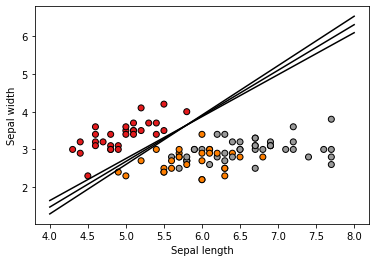

In [10]:
[plt.plot(*lines(i,Beta,Int),color='k') for i in range(3)]
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [14]:
#there are three classes, so we should have 2 separating lines. We always think of separating the 0th class from the k-1 other classes. We can just easily ignore the parameters for the first class
Beta = Beta - Beta[0,:]
Int = Int - Int[0]

In [15]:
Beta

array([[  0.        ,   0.        ],
       [ 59.06562304, -50.2731844 ],
       [ 61.31646812, -49.41946854]])

Text(0, 0.5, 'Sepal width')

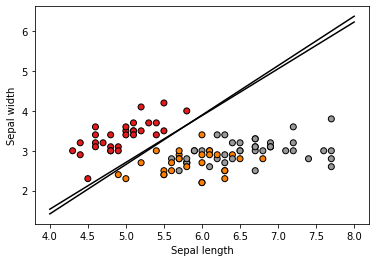

In [16]:
[plt.plot(*lines(i,Beta,Int),color='k') for i in range(3)]
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [17]:
# this is one vs rest classification
svovr = svm.LinearSVC(multi_class = 'ovr',max_iter=2000)
svovr.fit(X_tr,y_tr)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [18]:
Beta_svovr, Int_svovr = svovr.coef_, svovr.intercept_

Text(0, 0.5, 'Sepal width')

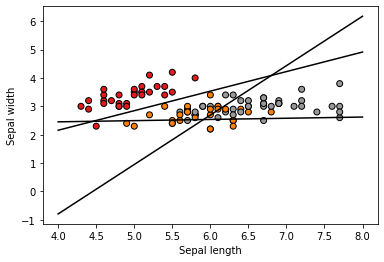

In [19]:
[plt.plot(*lines(i,Beta_svovr,Int_svovr),color='k') for i in range(3)]
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [20]:
# this is one vs one classification
svovo = svm.SVC(kernel='linear')
svovo.fit(X_tr,y_tr)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
Beta_svovo, Int_svovo = svovo.coef_, svovo.intercept_

Text(0, 0.5, 'Sepal width')

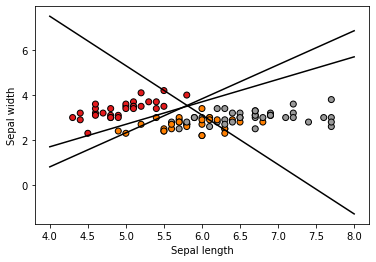

In [22]:
[plt.plot(*lines(i,Beta_svovo,Int_svovo),color='k') for i in range(3)]
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=plt.cm.Set1,edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [33]:
df_lr = lr.decision_function(X_te)
df_ovo = svovo.decision_function(X_te)
df_ovr = svovr.decision_function(X_te)

l = 0
bin_y = (y_te == l)*1
fpr_lr, tpr_lr, _ = metrics.roc_curve(bin_y, df_lr[:,l])
fpr_ovo, tpr_ovo, _ = metrics.roc_curve(bin_y, df_ovo[:,l])
fpr_ovr, tpr_ovr, _ = metrics.roc_curve(bin_y, df_ovr[:,l])

In [34]:
def plotfun(l):
    plt.figure()
    lw = 2
    plt.plot(fpr_lr, tpr_lr,lw=lw, label="LR")
    plt.plot(fpr_ovo, tpr_ovo,lw=lw, label="SVM OVO")
    plt.plot(fpr_ovr, tpr_ovr,lw=lw, label="SVM OVR")
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {l} vs rest ROC')
    plt.legend(loc="lower right")
    plt.show()

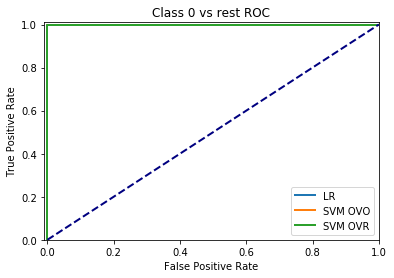

In [35]:
plotfun(l)

In [26]:
df_lr = lr.decision_function(X_te)
df_ovo = svovo.decision_function(X_te)
df_ovr = svovr.decision_function(X_te)

l = 1
bin_y = (y_te == l)*1
fpr_lr, tpr_lr, _ = metrics.roc_curve(bin_y, df_lr[:,l])
fpr_ovo, tpr_ovo, _ = metrics.roc_curve(bin_y, df_ovo[:,l])
fpr_ovr, tpr_ovr, _ = metrics.roc_curve(bin_y, df_ovr[:,l])

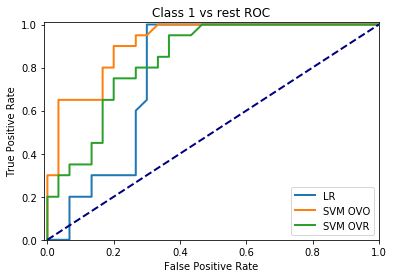

In [27]:
plotfun(l)

In [28]:
df_lr = lr.decision_function(X_te)
df_ovo = svovo.decision_function(X_te)
df_ovr = svovr.decision_function(X_te)

l = 2
bin_y = (y_te == l)*1
fpr_lr, tpr_lr, _ = metrics.roc_curve(bin_y, df_lr[:,l])
fpr_ovo, tpr_ovo, _ = metrics.roc_curve(bin_y, df_ovo[:,l])
fpr_ovr, tpr_ovr, _ = metrics.roc_curve(bin_y, df_ovr[:,l])

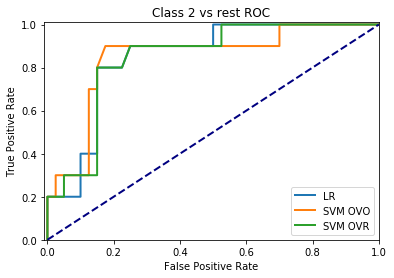

In [29]:
plotfun(l)